In [1]:
import torch 
import models_torch as models 
import utils 


In [2]:
device =  'cuda' if torch.cuda.is_available() else 'cpu'

In [101]:
# making a quick dummy dataset to use mammogram loaders 
from torch.utils.data import dataloader,Dataset
import  torchvision.transforms  as pytrans 
from PIL import Image 
import numpy as np 
import pandas as pd 
class kerasMammoLoader(Dataset):
    def __init__(self,path):
        super().__init__()
        self.data = pd.read_csv(path,dtype='str') 
        self.pids =  self.data['acc_anon'].unique()
        self.transforms=  pytrans.Compose([
            pytrans.ConvertImageDtype(torch.float16),
            pytrans.Lambda(lambda x: x.repeat(1,1,1,1)),
            pytrans.Normalize(0,1)
        ])
    def load_mamo(self,df_row):
        img_path = df_row['hiti_path']
        with  Image.open(img_path) as pil_img :
            arr = np.array( pil_img )
        #crop  = eval(df_row['crop_idx'])
        view = df_row['ViewPosition']
        lateral = df_row['ImageLaterality']
        tissueden = df_row['tissueden']
        #img =  torch.tensor(arr[crop[1]:crop[1]+crop[3],crop[0]:crop[0]+crop[2] ] )
        img = torch.tensor(arr)
        img = self.transforms(img)
        print(img.shape)
        return (view,lateral,img,tissueden,img_path)

    def __getitem__(self,idx): 
        pid = self.pids[idx]
        study_df = self.data[self.data['acc_anon'] == pid]
        imgs_dict =  dict() 
        imgs_path  = list()
        for i,e in study_df.iterrows():
            (view,lateral,img,tissueden,img_path) =self.load_mamo(e)
            imgs_dict[f"{lateral}-{view}"]  = img
            imgs_path.append(img_path)
        return (imgs_dict,imgs_path)



In [82]:
imgs
print(lateral)
print(views)

['L', 'R', 'R', 'L']
['MLO', 'MLO', 'CC', 'CC']


In [102]:
from glob import glob 
imgs= glob('./images/*.png')
lateral = [e.split('/')[-1].split('-')[0] for e in imgs] 
views  = [e.split('/')[-1].split('.')[0].split('-')[-1] for e in imgs ]
fake_dens = ['0' for e in range(len(imgs))]
fake_df = pd.DataFrame({'hiti_path':imgs,'tissueden':fake_dens,'acc_anon':['pedro']*4,'ImageLaterality':lateral,'ViewPosition':views})
fake_df.to_csv('samples.csv',index=False)

In [103]:
data = kerasMammoLoader('./samples.csv')

In [111]:
imgs,other  = data.__getitem__(0)

torch.Size([1, 3, 2600, 2000])
torch.Size([1, 3, 2600, 2000])
torch.Size([1, 3, 2600, 2000])
torch.Size([1, 3, 2600, 2000])


In [105]:
actual_img[0][0].shape

torch.Size([2600, 2000])

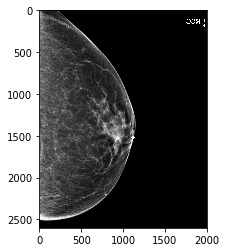

In [106]:
actual_img = imgs['R-CC']
plt.imshow(actual_img[0][0].type(torch.float),cmap='gray')

In [107]:
import matplotlib.pyplot as plt 


In [108]:
        model = models.BaselineBreastModel(device, nodropout_probability=1.0, gaussian_noise_std=0.0).to(device)

In [109]:
model_path = './saved_models/BreastDensity_BaselineBreastModel/model.p'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [110]:
with torch.no_grad(): 
    pred = model(imgs).cpu().numpy()

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 3, 2600, 2000] to have 1 channels, but got 3 channels instead